In [1]:
# copied from

In [134]:
import pandas as pd
from metrics import get_baseline_data
import numpy as np
import math
import tensorflow
import matplotlib.pyplot as plt
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import RobustScaler

In [3]:
data = get_baseline_data("raw_data/preproc_data_rate.csv")
data_wo_date = data.drop(columns="Date")

In [12]:
def subsample_sequence(data, length): # Return a shorter dataframe with specified length
    last_possible = data.shape[0] - length
    random_start = np.random.randint(0, last_possible)
    data_sample = data[random_start: random_start+length]
    return data_sample

def split_subsample_sequence(data, length): # Return a random sequence of specified length
    data_subsample = subsample_sequence(data, length)
    y_sample = data_subsample.iloc[length-31:]

    X_sample = data_subsample[0:length-31]
    X_sample = X_sample.values
    return np.array(X_sample), np.array(y_sample)

def get_X_y(data, n_sequences, length): # Return a sepcific number of (X,y) samples of specified length for all adm. regions

    X, y = [], []

    for i in range(n_sequences):
        (xi, yi) = split_subsample_sequence(data, length)
        X.append(xi)
        y.append(yi)

    X = np.array(X)
    y = np.array(y)
    return X, y

def get_train_test(data,n_sequences,length): # Return train and test data
    data_wo_date = data.drop(columns="Date")

    len_ = int(0.8*data_wo_date.shape[0])
    data_train = data_wo_date[:len_]
    data_test = data_wo_date[len_:]

    test_seq = math.floor(n_sequences/4)

    X_train, y_train = get_X_y(data_train, n_sequences, length)
    X_test, y_test = get_X_y(data_test, test_seq, length)

#     X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
#     X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)

    return X_train, y_train, X_test, y_test

def model(number_of_sequences, input_sequence_length, number_of_regions, prediction_horizon):
# number_of_sequences = 1000 # number of data sequences for training
# input_sequence_length = 169 # sequence length in training process
# number_of_regions = 30 # number of region sin training process
# prediction_horizon = 31 # number of predicted days by region
#X_train_shape = (number_of_sequences, input_sequence_length, number_of_regions)
#y_train_shape = (number_of_sequences, input_sequence_length, number_of_regions)

    model = models.Sequential()
    model.add(layers.LSTM(40, return_sequences=False, activation="tanh", input_shape = (input_sequence_length, number_of_regions)))
    model.add(layers.RepeatVector(prediction_horizon))
    
    model.add(layers.LSTM(40, return_sequences=True, activation="tanh"))
    model.add(layers.TimeDistributed(layers.Dense(number_of_regions,"relu")))
    model.compile(loss="mse",
                optimizer="rmsprop")
    return model

def fit_model(X_train, y_train, model):
    es = EarlyStopping(monitor='val_loss', verbose=1, patience=20, restore_best_weights=True)
    hist = model.fit(X_train, y_train, callbacks=[es],epochs = 2000,validation_split =0.3, batch_size=32)
    return hist


In [13]:
_,_, X_test, y_test = get_train_test(data,1000,200)

In [14]:
X_test

array([[[0.04421755, 0.04115907, 0.04331191, ..., 0.18031257,
         0.08806189, 0.05591356],
        [0.0821183 , 0.05199041, 0.04787106, ..., 0.4733205 ,
         0.10273887, 0.06290275],
        [0.05685113, 0.02382894, 0.03647319, ..., 0.36062514,
         0.13943133, 0.15376228],
        ...,
        [0.10102235, 0.03881725, 0.03899036, ..., 0.16232035,
         0.02987813, 0.07815664],
        [0.05051117, 0.0474433 , 0.04548875, ..., 0.27826345,
         0.05975625, 0.09947209],
        [0.11365014, 0.03666073, 0.03682423, ..., 0.04637724,
         0.10457344, 0.12078753]],

       [[0.07576676, 0.05175633, 0.03249196, ..., 0.41739518,
         0.06722579, 0.09236694],
        [0.05051117, 0.04097376, 0.02382744, ..., 0.23188621,
         0.06722579, 0.07105149],
        [0.06313897, 0.03019119, 0.03682423, ..., 0.16232035,
         0.04481719, 0.04263089],
        ...,
        [0.07573204, 0.05581804, 0.0474592 , ..., 0.19101376,
         0.06844804, 0.07225016],
        [0.0

In [16]:
from tensorflow import keras
model_AK = keras.models.load_model('RNN_LSTM')
model_AK.summary()
y_predict = model_AK.predict(X_test)

Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_110 (LSTM)             (None, 40)                11360     
                                                                 
 repeat_vector_25 (RepeatVec  (None, 31, 40)           0         
 tor)                                                            
                                                                 
 lstm_111 (LSTM)             (None, 31, 40)            12960     
                                                                 
 time_distributed_66 (TimeDi  (None, 31, 30)           1230      
 stributed)                                                      
                                                                 
Total params: 25,550
Trainable params: 25,550
Non-trainable params: 0
_________________________________________________________________


In [22]:
len(X_test[0][0])

30

In [25]:
len(y_test[0][0])

30

performances computed on test set:0.08908342570066452


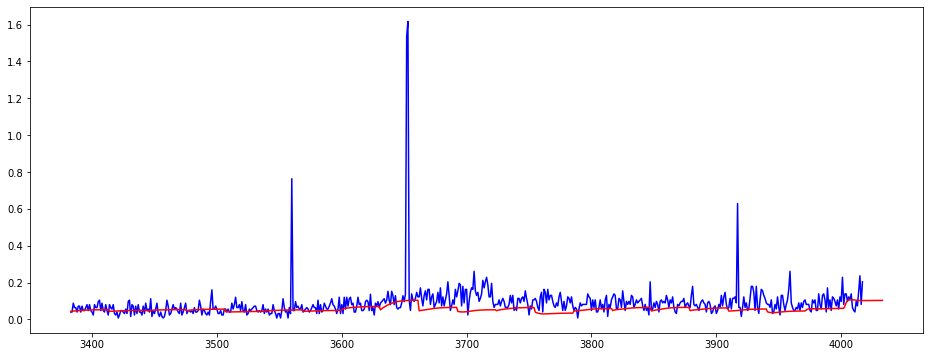

In [199]:
y_pred_df = compute_plot_pred(data,200)

In [186]:
y_pred_df[:40]

,Anchieta,Bangu,Barra da Tijuca,Botafogo,Campo Grande,Centro,Cidade de Deus,Complexo do Alemao,Copacabana,Guaratiba,...,Portuaria,Ramos,Realengo,Rio Comprido,Rocinha,Santa Cruz,Santa Teresa,Sao Cristovao,Tijuca,Vila Isabel
index,,,,,,,,,,,,,,,,,,,,,
3383,0.010108,0.002705,0.0,0.029038,0.028650,0.0,0.0,0.0,0.044199,0.021641,...,0.006447,0.029561,0.023453,0.005122,0.0,0.0,0.037407,0.033560,0.022143,0.005126
3384,0.011100,0.000000,0.0,0.038580,0.029663,0.0,0.0,0.0,0.044972,0.020687,...,0.005993,0.033563,0.028184,0.004388,0.0,0.0,0.059245,0.045433,0.015210,0.008786
3385,0.013026,0.000000,0.0,0.045355,0.030597,0.0,0.0,0.0,0.045605,0.019640,...,0.006447,0.036000,0.031719,0.004487,0.0,0.0,0.078331,0.054183,0.010331,0.011664
3386,0.015329,0.000000,0.0,0.050172,0.031446,0.0,0.0,0.0,0.046179,0.018661,...,0.007361,0.037503,0.034406,0.005199,0.0,0.0,0.094708,0.060658,0.007050,0.013988
3387,0.017669,0.000000,0.0,0.053597,0.032208,0.0,0.0,0.0,0.046734,0.017819,...,0.008479,0.038443,0.036482,0.006317,0.0,0.0,0.108546,0.065455,0.004990,0.015884
3388,0.019852,0.000000,0.0,0.056024,0.032884,0.0,0.0,0.0,0.047282,0.017129,...,0.009656,0.039036,0.038108,0.007668,0.0,0.0,0.120088,0.069000,0.003843,0.017430
3389,0.021783,0.000000,0.0,0.057735,0.033480,0.0,0.0,0.0,0.047824,0.016584,...,0.010813,0.039410,0.039392,0.009117,0.0,0.0,0.129607,0.071606,0.003361,0.018682
3390,0.023425,0.000000,0.0,0.058929,0.033999,0.0,0.0,0.0,0.048356,0.016165,...,0.011906,0.039643,0.040414,0.010569,0.0,0.0,0.137379,0.073504,0.003348,0.019684
3391,0.024781,0.000000,0.0,0.059751,0.034448,0.0,0.0,0.0,0.048868,0.015852,...,0.012914,0.039782,0.041229,0.011956,0.0,0.0,0.143668,0.074869,0.003651,0.020476


In [169]:
y_pred_0

[[0.01010830793529749,
  0.0027054501697421074,
  0.0,
  0.02903818152844906,
  0.028650054708123207,
  0.0,
  0.0,
  0.0,
  0.04419926553964615,
  0.021641362458467484,
  0.0070512862876057625,
  0.013228416442871094,
  0.013712985441088676,
  0.03422386571764946,
  0.0,
  0.017777681350708008,
  0.0296621210873127,
  0.0,
  0.0026648864150047302,
  0.013911155983805656,
  0.00644745072349906,
  0.02956056408584118,
  0.023452993482351303,
  0.0051218620501458645,
  0.0,
  0.0,
  0.03740737587213516,
  0.03355993330478668,
  0.022142812609672546,
  0.005126495845615864],
 [0.011099569499492645,
  0.0,
  0.0,
  0.0385800302028656,
  0.02966325730085373,
  0.0,
  0.0,
  0.0,
  0.044971730560064316,
  0.020687291398644447,
  0.006874449085444212,
  0.017861375585198402,
  0.01619420386850834,
  0.03576265275478363,
  0.0,
  0.01758509874343872,
  0.03410426527261734,
  0.0,
  0.008799625560641289,
  0.019213519990444183,
  0.005993446335196495,
  0.033563002943992615,
  0.028184216469526